In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import regex as re

from matplotlib.ticker import MaxNLocator

In [3]:
import matplotlib.patches as mpatches

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Allow all columns and 30 rows to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

In [6]:
#set seaborn plotting aesthetics
sns.set(style='whitegrid')
sns.set_context('notebook')

### Set up functions 

In [7]:
# define a function to clean the white spaces
def strip_strings(my_list):
    stripped = [s.strip() for s in my_list]
    return stripped

# define function, one in which we return answers that corresponds to the selected answer choices
def return_same(text, list1):
    sames = np.intersect1d(text, list1)
    return sames

# define a function that vectorizes responses from multi-choice questions
def make_vectorized_answers(dataframe, column):
    
    df = dataframe[[column]].copy()
    df[column] = df[column].replace('^\t', '', regex=True)
    
    #Make a list of the answers 
    answer_choices = df[column].dropna().unique().tolist()
    answer_choices = ', '.join(answer_choices)
    answer_choices = answer_choices.split(',')
    answer_choices = strip_strings(answer_choices)
    answer_choices = [*set(answer_choices)]
    
    # make the column into a list for each answer that will go into the needs dataframe
    df['answer_list'] = df[column].str.split(',\s*')
    
     # transform the column:
    df['answer_list'] = df['answer_list'].apply(lambda x: strip_strings(x) if(np.all(pd.notnull(x))) else x)
    
    # make a new column for the answers that corresponded to the answer choices 
    df['answers'] = df['answer_list'].apply(lambda x: return_same(x, answer_choices))
    
    # Turn the returned list into a string for the 'answers' and 'other' columns
    df['answers'] = df['answers'].apply(lambda x: ', '.join(set(x.astype(str))))
    
    # vectorize responsed that fall under the selected answer choices 
    df_dummy = df['answers'].str.get_dummies(sep=', ')
    
    return df_dummy

In [8]:
# function to clean up the race column
def return_race(text):
    text = str(text)
    if text == 'White':
        return 'White'
    if text == 'Hispanic':
        return 'Hispanic/Latino'
    if text == 'Hispanic, Latino/a/x, or Latin American':
        return 'Hispanic/Latino'
    if text == 'Black':
        return 'Black/African American'
    if text == 'Black or African American':
        return 'Black/African American'
    if text == 'Asian or Asian American' or text == 'Asian' or text == 'Asian ':
        return 'Asian/Asian American'
    if text == 'Native American':
        return 'American Indian/Alaska Native'
    if text == 'American Indian - Alaska Native - or Indigenous':
        return 'American Indian/Alaska Native'
    if text == 'Native Hawaiian or Pacific Islander':
        return 'Native Hawaiian/Pacific Islander'
    if text == 'Middle Eastern': 
        return 'Middle Eastern'
    if 'Multiracial' in text:
        return 'Multiracial/Multi-ethnic'
    if 'Asian' in text or 'Black' in text or 'Indi' in text or 'Latino' in text or 'Middle' in text or 'Alaska' in text: 
        return 'Multiracial/Multi-ethnic'
    if 'White' in text:
        return 'White'
    else:
        return 'Other/Prefer not to answer'

## Upload all the ARISE community surveys

Upload surveys and select the survey answers that will be analyzed in this notebook. Also rename columns for consistency across all community surveys. Create a column named 'source' that identifies the community from which the survey is sourced. 

In [9]:
wellbeing = pd.read_excel('./Data/ARISE_wellbeing.xlsx', sheet_name='well-being')

In [10]:
wellbeing = wellbeing[['current_wellbeing', 'future_wellbeing', 'financial_wellbeing', 'needs',
                      'great_community', 'community_belonging', 'institutional trust', 'emotionally_upset',
                      'main_reason', 'race']].copy()

In [11]:
wellbeing['source'] = 'general'

In [12]:
heart_full = pd.read_excel('./Data/ARISE_HEART_well-being.xlsx', sheet_name='Full')

In [13]:
heart_full = heart_full[['current_wellbeing', 'future_wellbeing', 'financial_wellbeing', 'needs',
                      'great_community', 'community_belonging', 'institutional trust', 'emotionally_upset',
                        'main_reason', 'race']].copy()

In [14]:
heart_full['source'] = 'Full Heart Survey'

In [15]:
heart_part1 = pd.read_excel('./Data/ARISE_HEART_well-being.xlsx', sheet_name='Part I')

In [16]:
heart_part1 = heart_part1[['current_wellbeing', 'future_wellbeing', 'financial_wellbeing', 'needs', 'race']].copy()

In [17]:
heart_part1['source'] = 'Heart Part 1'

In [18]:
heart_part2 = pd.read_excel('./Data/ARISE_HEART_well-being.xlsx', sheet_name='Part II')

In [19]:
heart_part2 = heart_part2[['current_wellbeing', 'future_wellbeing', 
                      'great_community', 'community_belonging', 'institutional_trust', 'emotionally_upset',
                          'main_reason', 'race']].copy()

In [20]:
heart_part2.rename(columns={'institutional_trust': 'institutional trust'}, inplace=True)

In [21]:
heart_part2['source'] = 'Heart Part 2'

In [22]:
kankakee_1 = pd.read_excel('./Data/ARISE_Kankakee.xlsx', sheet_name='Parent')

In [23]:
kankakee_1 = kankakee_1[['current_wellbeing', 'future_wellbeing', 'needs',
                      'great_community', 'community_belonging', 'institutional trust', 'emotionally_upset',
                        'main_reason', 'race']].copy()

In [24]:
kankakee_1['source'] = 'Kankakee Parents'

In [25]:
kankakee_2 = pd.read_excel('./Data/ARISE_Kankakee.xlsx', sheet_name='Youth')

In [26]:
kankakee_2 = kankakee_2[['current_wellbeing', 'future_wellbeing',
                      'great_community', 'institutional trust', 'race']].copy()

In [27]:
kankakee_2['source'] = 'Kankakee Youth'

In [28]:
black_brown = pd.read_csv('./Data/ARISE_Wellness_Black_brown.csv')

In [29]:
black_brown = black_brown[['current_wellbeing', 'great_community', 'needs', 'institutional_trust', 'race']].copy()

In [30]:
black_brown.rename(columns={'institutional_trust': 'institutional trust'}, inplace=True)

In [31]:
black_brown['source'] = 'Black and Brown'

### Inspect columns for each dataframe

I am taking a look at all the column names and making sure that they are consistent across all dataframes. This is a necessary step to join all the survey responses across communities. 

In [32]:
wellbeing.columns

Index(['current_wellbeing', 'future_wellbeing', 'financial_wellbeing', 'needs',
       'great_community', 'community_belonging', 'institutional trust',
       'emotionally_upset', 'main_reason', 'race', 'source'],
      dtype='object')

In [33]:
heart_full.columns

Index(['current_wellbeing', 'future_wellbeing', 'financial_wellbeing', 'needs',
       'great_community', 'community_belonging', 'institutional trust',
       'emotionally_upset', 'main_reason', 'race', 'source'],
      dtype='object')

In [34]:
heart_part1.columns

Index(['current_wellbeing', 'future_wellbeing', 'financial_wellbeing', 'needs',
       'race', 'source'],
      dtype='object')

In [35]:
heart_part2.columns

Index(['current_wellbeing', 'future_wellbeing', 'great_community',
       'community_belonging', 'institutional trust', 'emotionally_upset',
       'main_reason', 'race', 'source'],
      dtype='object')

In [36]:
kankakee_1.columns

Index(['current_wellbeing', 'future_wellbeing', 'needs', 'great_community',
       'community_belonging', 'institutional trust', 'emotionally_upset',
       'main_reason', 'race', 'source'],
      dtype='object')

In [37]:
kankakee_2.columns

Index(['current_wellbeing', 'future_wellbeing', 'great_community',
       'institutional trust', 'race', 'source'],
      dtype='object')

In [38]:
black_brown.columns

Index(['current_wellbeing', 'great_community', 'needs', 'institutional trust',
       'race', 'source'],
      dtype='object')

### Concatenate all the dfs

In [39]:
dfs = [wellbeing, heart_full, heart_part1, heart_part2, kankakee_1, kankakee_2, black_brown]

In [40]:
all_surveys = pd.concat(dfs, axis=0)

In [41]:
all_surveys.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2470 entries, 0 to 816
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   current_wellbeing    2110 non-null   float64
 1   future_wellbeing     1360 non-null   float64
 2   financial_wellbeing  1321 non-null   float64
 3   needs                2156 non-null   object 
 4   great_community      2030 non-null   object 
 5   community_belonging  446 non-null    object 
 6   institutional trust  1966 non-null   object 
 7   emotionally_upset    1295 non-null   object 
 8   main_reason          205 non-null    object 
 9   race                 2166 non-null   object 
 10  source               2470 non-null   object 
dtypes: float64(3), object(8)
memory usage: 231.6+ KB


### Respondents wellbeing

Cantril's scale was used to assessed respondent's wellbeing. Respondents choose from a ladder with steps numbered from 0-10 to indicate where they currently feel their lives are. 

We have to use these numbered responses to categorize whether the responded is thriving, struggling, or suffering. Those who indicate their wellbeing as falling between 10 -7 are thriving, those who fall between 5 and 6 are struggling, and those who are between 0-4 are suffering. 

In [42]:
# conditions are logical conditions that will be used to categorize numerical responses
# categories is a list of the corresponding categories

conditions = [
    (all_surveys['current_wellbeing'] <= 4),
    (all_surveys['current_wellbeing'] > 4) & (all_surveys['current_wellbeing'] < 7),
    (all_surveys['current_wellbeing'] >= 7)
]

categories = ['Suffering', 'Struggling', 'Thriving']

In [43]:
# create a new column with the wellbeing categories based on the coditions and categories specified above
all_surveys['wellbeing_category'] = np.select(conditions, categories)

In [44]:
# the 0 below indicates rows with nan (respondent skipped this question most likely)
all_surveys['wellbeing_category'].value_counts()

Thriving      1126
Struggling     629
0              360
Suffering      355
Name: wellbeing_category, dtype: int64

In [45]:
# make a dataframe with the counts of each wellbeing category and name the count column 'total'
wellbeing_pie = all_surveys.groupby('wellbeing_category').count().reset_index().rename(columns={'current_wellbeing':'total'})

In [46]:
wellbeing_pie = wellbeing_pie[['wellbeing_category', 'total']].drop(index=0)

In [47]:
# let's look at the count and make sure the '0' category was dropped
wellbeing_pie

,wellbeing_category,total
1,Struggling,629
2,Suffering,355
3,Thriving,1126


In [48]:
# let's look at the total of those who answered the wellbeing question and get the 'n' value
wellbeing_pie['total'].sum()

2110

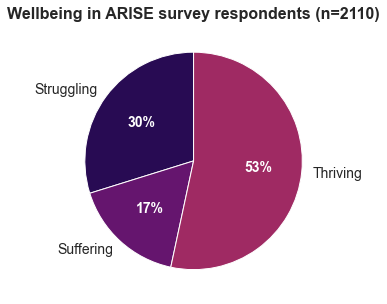

In [49]:
# make a pie graph with a few customazations 

plt.figure(figsize=(5,5))
patches, texts, autotexts = plt.pie(x=wellbeing_pie['total'], labels=wellbeing_pie['wellbeing_category'],
                                                       autopct='%1.0f%%', 
                                                       startangle=90, 
                                                       colors = sns.color_palette('inferno'))

plt.title('Wellbeing in ARISE survey respondents (n=2110)',
         fontdict={'size':16, 'fontweight': 'bold'})

for text in texts:
    text.set_size(14);
    
for autotext in autotexts:
    autotext.set_horizontalalignment('center')
    autotext.set_color('w')
    autotext.set_fontweight('bold')
    autotext.set_size(14)

plt.savefig('./Figures/ARISE wellbeing totals', bbox_inches = 'tight', edgecolor='w')

### Most cited community needs

To assess community needs, survey takers were asked what would most improve their lives (i.e. food, transportation, childcare). This question allowed respondents to check all that apply. On our end we received respondent's asnwer in one column, seperated by a comma. 

To analyze community needs, we vectorized the answer choices. We also presented made a chart of the top community needs. 

In [50]:
needs_df = make_vectorized_answers(all_surveys, 'needs')

In [51]:
# One survey provided 'Health insurance' as an answer as opposed to 'Health Insurance', we are joining the
# answers into one column. 
needs_df['Health Insurance'] = needs_df['Health Insurance'] + needs_df['Health insurance']

needs_df.drop(columns='Health insurance', inplace=True)

In [52]:
# select top 20 cited community needs
needs_count = needs_df.sum().sort_values(ascending=False)[:21]

In [53]:
# eliminate 'nothing I need help with' and focus on only cited needs
needs_count.drop('Nothing I need help with', inplace=True)

In [54]:
# get the % of survey respondents who cited each need
total_respondents = needs_df.shape[0]

needs_count = (needs_count/total_respondents)*100
needs_count = needs_count.astype('int')

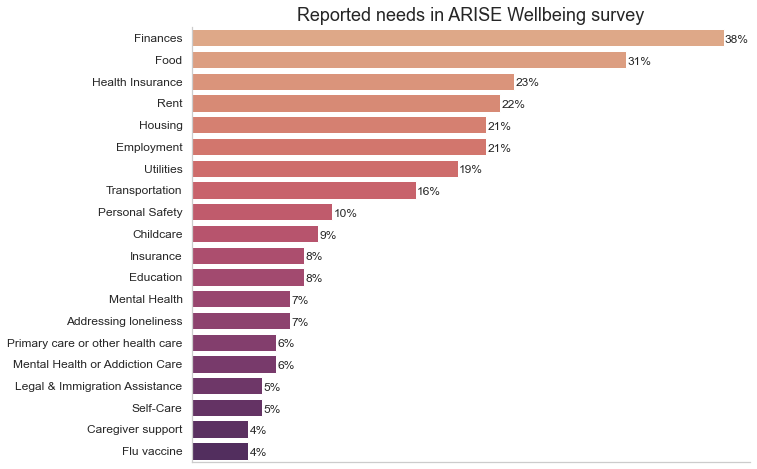

In [55]:
# plot community needs as a bar graph

n = len(needs_count.index)
i = int(needs_count.max())+1

plt.figure(figsize=(10, 8))
g = sns.barplot(y=needs_count.index, x=needs_count, palette='flare')
g.set_xticks(range(i))
sns.despine(right=True, top=True)
plt.title('Reported needs in ARISE Wellbeing survey', fontdict={'size': 18})
plt.yticks(fontsize=12)
plt.xticks([])

for x, y, p in zip(needs_count.round(2), range(n),  needs_count.round(2)):
    p = str(p) + '%'
    plt.text(x+.1, y+.22, p, fontdict={'fontweight':'book'})
    
plt.savefig('./Figures/'+  'Reported needs in ARISE survey' , bbox_inches = 'tight', edgecolor='w')

In [56]:
# Create a new dataframe with responses that only includes needs, and not eliminates 
# answers were respondents did not specify a need
# Will use this new dataframe to count how many respondents identified 2 needs or more
# and how many respondents identified 3 needs or more.

clean_needs = needs_df.drop(columns=['Already have help.','Nothing I need help with','Other:', 'Prefer not to answer'])

In [57]:
personal_needs_count = clean_needs.sum(axis=1)

In [58]:
(personal_needs_count>=2).sum()

1486

In [59]:
# What proportion of respondents cited 2 or more needs
1486/total_respondents

0.6016194331983805

In [60]:
(personal_needs_count>=3).sum()

1163

In [61]:
# what proportion of respondents cited 3 or more needs
1163/total_respondents

0.4708502024291498

### Better community

Survey takers were asked which conditions would help make their community great. Respondents were allow to pick 3 choices. All these choices were provided to us in one column. To extract the top suggections for a better community, we seperated and vectorized the answers that respondents selected. 

In [62]:
community_df = make_vectorized_answers(all_surveys, 'great_community')

In [63]:
community_count = community_df.sum().sort_values(ascending=False)[:10]

In [64]:
community_count.index.tolist()

['Everyone feels like they belong',
 'Everyone works to make the community better for everyone else',
 'Everyone feels safe',
 'Our community has access to good jobs that make it possible to live and provide for family',
 'Our community has access to affordable and humane housing',
 'People take care of each other and care about others',
 'Most people help other people to feel welcome and take part in our community',
 'Our community makes it easy to access basic needs for health and health care',
 'Our community makes it easy to afford healthy food',
 'Our community is welcoming of people of all races and cultures']

In [65]:
# these answer choices are very long and would make plotting them awkward. 
# we are rephrasing them for the purpose of making a bar chart

new_index = ['Belonging for all','Collective community improvement', 'Sense of safety',
             'Available thriving livelihoods', 'Affordable and humane housing', 'Compassionate community',
             'Inclusive participation and support', 'Access to healthcare and basic needs',
             'Access to affordable food', 'Welcoming diversity and inclusion']

In [66]:
community_count.index = new_index

community_count = round((community_count/total_respondents)*100)

community_count = community_count.astype('int')

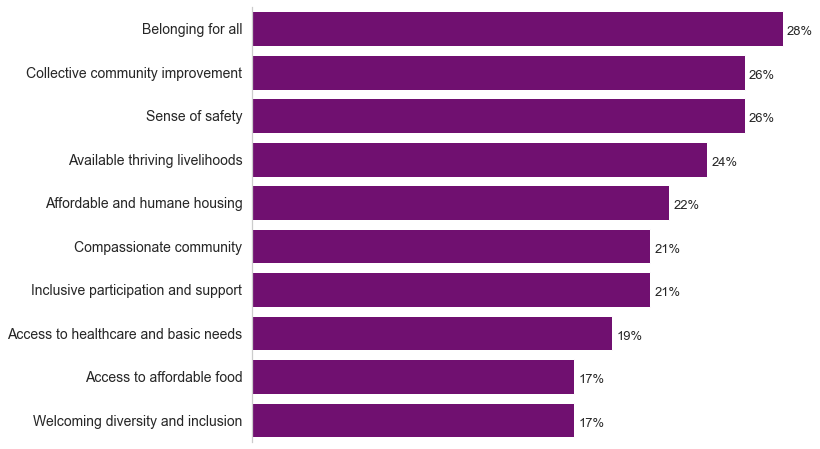

In [67]:
n = len(community_count.index)
i = int(community_count.max())+1

plt.figure(figsize=(10, 8))
g = sns.barplot(y=community_count.index, x=community_count, color='#800080')
g.set_xticks(range(i))
sns.despine(right=True, top=True, bottom=True)
plt.yticks(fontsize=14)
plt.xticks([])

for x, y, p in zip(community_count.round(2), range(n),  community_count.round(2)):
    p = str(p) + '%'
    plt.text(x+.2, y+.15, p, fontdict={'fontsize':13})
    
plt.savefig('./Figures/'+  'Better community' , bbox_inches = 'tight', edgecolor='w')

### Community belonging

Survery asked respondents an open question on what makes them feel like they belong in their community. As an initial analysis, we will do a word cloud and bar graph with the most used words. 

#### word cloud

In [68]:
text = all_surveys['community_belonging']

In [69]:
from wordcloud import WordCloud, STOPWORDS

additional_words = {'Nan', 'Nothing', 'Community'}

In [70]:
comment_words = ''
stopwords = STOPWORDS|additional_words

In [71]:
# iterate through the csv file
for val in text:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].capitalize()
     
    comment_words += " ".join(tokens)+" "
 

In [72]:
wordcloud = WordCloud(width = 1000, height = 600,
                      background_color ='white',
                      colormap='flare',
                      stopwords = stopwords,
                      min_font_size = 12,
                      max_words=80,
                      relative_scaling=.5,
                      min_word_length=3,
                      prefer_horizontal=1
        
                     ).generate(comment_words)

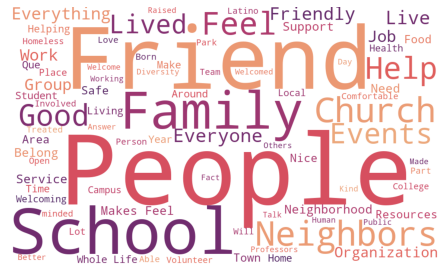

In [73]:
# plot the WordCloud image                      
plt.figure(figsize = (6,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('./Figures/'+  'community belonging' , bbox_inches = 'tight', edgecolor='w')

In [74]:
text = all_surveys[['community_belonging']]

In [75]:
text.dropna(inplace=True)

In [76]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words = stop_words + ['my', 'the', 'like', 'here', 'nothing', 'lived']
text['community_belonging'] = text['community_belonging'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luisagonzalez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [77]:
# vectorize each word found in the collection of responses

from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
# fit the corpus to CountVectorizer
count_vect.fit(text['community_belonging'])

vec_words = count_vect.transform(text['community_belonging'])

In [78]:
vec_df = pd.DataFrame(columns=count_vect.get_feature_names(), data=vec_words.toarray())

In [79]:
vec_df.shape

(446, 781)

In [80]:
word_count = vec_df.sum().sort_values(ascending=False)[:14]

In [81]:
word_count

community    79
people       51
my           40
friends      37
the          33
feel         29
family       28
church       25
neighbors    25
here         23
school       22
good         18
help         17
events       17
dtype: int64

In [82]:
# eliminate words that do not have more explanatory power without context
word_count = word_count.drop(['my', 'the', 'here', 'help'])

In [83]:
new_index = [i.capitalize() for i in word_count.index.to_list()]

In [84]:
word_count.index = new_index

In [85]:
word_count = word_count.sort_values(ascending=False)

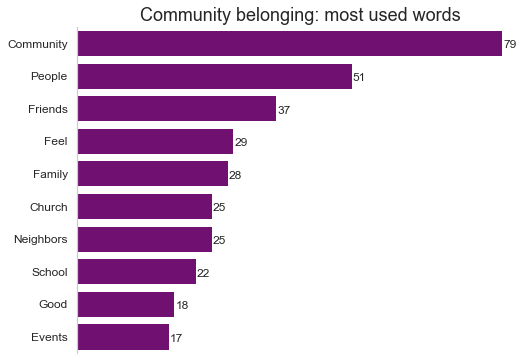

In [86]:
# plot the top ten words in the community belonging questions
n = len(word_count.index)
i = int(word_count.max())+1

plt.figure(figsize=(8, 6))
g = sns.barplot(y=word_count.index, x=word_count, color='#800080')
g.set_xticks(range(i))
sns.despine(right=True, top=True, bottom=True)
plt.title('Community belonging: most used words', fontdict={'size': 18})
plt.yticks(fontsize=12)
plt.xticks([])

for x, y, p in zip(word_count.round(2), range(n),  word_count.round(2)):
    p = str(p) 
    plt.text(x+.2, y+.15, p, fontdict={'fontweight':'book'})
    
plt.savefig('./Figures/'+  'Word count bar' , bbox_inches = 'tight', edgecolor='w')

### Institutional Trust

The survey asked respondents to choose from a list of community groups and institutions which ones they trust. To understand which institutions are most trusted, we vectorized the answers and calculated the % of trust institutions have in the community. 

In [87]:
institutional = make_vectorized_answers(all_surveys, 'institutional trust')

institutional_count = (institutional.sum().sort_values(ascending=False)[:11]/total_respondents).round(2)

institutional_count = institutional_count*100

institutional_count = institutional_count.astype('int')

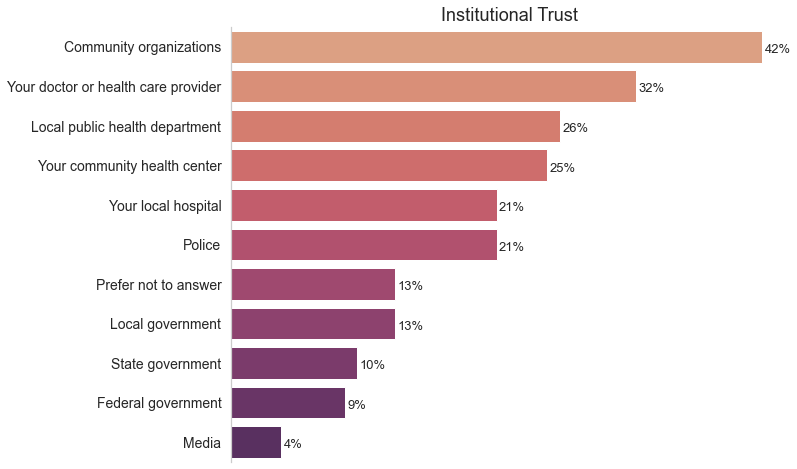

In [88]:
n = len(institutional_count.index)
i = int(institutional_count.max())+1

plt.figure(figsize=(10, 8))
g = sns.barplot(y=institutional_count.index, x=institutional_count, palette='flare')
g.set_xticks(range(i))
sns.despine(right=True, top=True, bottom=True)
plt.title('Institutional Trust', fontdict={'size': 18})
plt.yticks(fontsize=14)
plt.xticks([])

for x, y, p in zip(institutional_count, range(n),  institutional_count):
    p = str(p) + '%'
    plt.text(x+.2, y+.15, p, fontdict={'fontsize':13})
    
plt.savefig('./Figures/'+  'Institutional Trust' , bbox_inches = 'tight', edgecolor='w')

### Treated unfairly

Respondents were asked if they have felt that they have been treated unfairly for who they are. 

In [89]:
treated_pie = all_surveys['emotionally_upset'].value_counts(ascending=True)

treated_pie

Prefer not to answer    105
Yes                     219
No                      971
Name: emotionally_upset, dtype: int64

In [90]:
# number of individuals that answered this question
treated_pie.sum()

1295

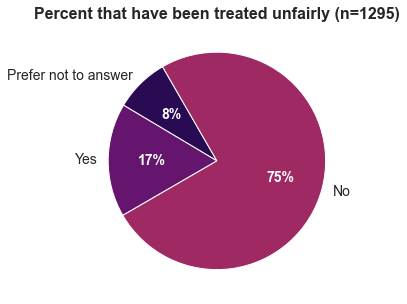

In [91]:
plt.figure(figsize=(5,5))
patches, texts, autotexts = plt.pie(x=treated_pie.values, labels=treated_pie.index,
                                                       autopct='%1.0f%%', 
                                                       startangle=120, 
                                                       colors = sns.color_palette('inferno'))

plt.title('Percent that have been treated unfairly (n=1295)',
         fontdict={'size':16, 'fontweight': 'bold'})

for text in texts:
    #text.set_fontweight('bold')
    text.set_size(14);
    
for autotext in autotexts:
    autotext.set_horizontalalignment('center')
    # autotext.set_fontstyle('italic')
    autotext.set_color('w')
    autotext.set_fontweight('bold')
    autotext.set_size(14)

plt.savefig('./Figures/ARISE treated unfairly totals', bbox_inches = 'tight', edgecolor='w')

In [92]:
# as a follow-up questions, respondents were asked to cite the main reason why they were treated unfairly
# only individuals who answered 'Yes' to the treated unfairly questions were prompted to answer this question

main_reason = make_vectorized_answers(all_surveys, 'main_reason')

In [93]:
# To find the proportion of reasons for treated unfairly, we created a new column to identify rows where
# respondents answered the question. Only rows where the sum across the columns is greater than 0 can be 
# counted. 

main_reason['count'] = main_reason.sum(axis=1)

(main_reason['count']>0).sum()

205

In [94]:
# select top 10 reasons divided by the number of people who answered the question
main_reason_pct = (main_reason.sum().sort_values(ascending=False)[:11])/205

main_reason_pct = (main_reason_pct.drop('count').round(2))

main_reason_pct = (main_reason_pct)*100

main_reason_pct = main_reason_pct.astype('int')

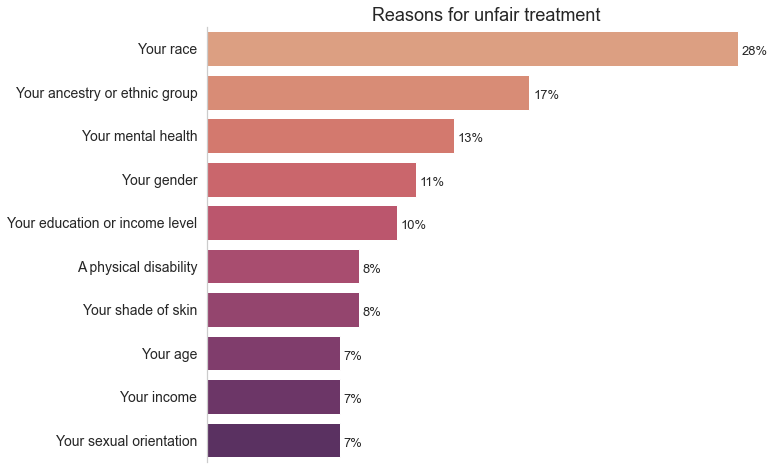

In [95]:
n = len(main_reason_pct.index)
i = int(main_reason_pct.max())+1

plt.figure(figsize=(10, 8))
g = sns.barplot(y=main_reason_pct.index, x=main_reason_pct.values, palette='flare')
g.set_xticks(range(i))
sns.despine(right=True, top=True, bottom=True)
plt.title('Reasons for unfair treatment', fontdict={'size': 18})
plt.yticks(fontsize=14)
plt.xticks([])

for x, y, p in zip(main_reason_pct, range(n),  main_reason_pct):
    p = str(p) + '%'
    plt.text(x+.2, y+.15, p, fontdict={'fontsize':13})
    
plt.savefig('./Figures/'+  'main reasons' , bbox_inches = 'tight', edgecolor='w')

### Treated unfairly by race group

The client would like to know which top reasons were cited by different group of survey respondents. Respondents were asked to self-identify their race or ethnicity. This question allowed respondents to select multiple choices and even do write-ins. All answers were provided in one column, making it difficult to analyze for those who may have selected multiple choices. In some instances respondents wrote-in their ancestry, which we are not using for our current analysis, therefore, certain selections need to cleaned. 

After we re-categorize respondents by race, we will analyze the top cited reasons for being treated unfairly of White, Black, and Latino respondents. 

In [97]:
    #Make a list of the answers 
    race_response = all_surveys['race'].dropna().unique().tolist()
    race_response = ', '.join(race_response)
    race_response = race_response.split(',')
    race_response = strip_strings(race_response)

In [98]:
race_response_unique = [*set(race_response)]

In [99]:
race_response_unique

['Naperville',
 'Middle Eastern/North African',
 'mestiza',
 'MESTIZO',
 'Middle Eastern',
 'Joliet',
 'Race or ethnicity not included above (Optional',
 'American Indian',
 'meztiso',
 'Prefer not to answer',
 'Multiracial or Multi-ethnic',
 'Native Hawaiian or Pacific Islander',
 'or Indigenous',
 'Latino/a/x',
 'or Latin American',
 'Black or African American',
 'Asian or Asian American',
 'Hispanic',
 'White',
 'mestizo',
 'Alaska Native',
 'please state):']

In [100]:
to_delete = [
 'Race or ethnicity not included above (Optional','MESTIZO','mestiza',
 'North African','meztiso','Joliet','mestizo','Naperville'
]

In [101]:
def eliminate_answers(text):
    for i in to_delete:
        if i in text:
            text = text.replace(', '+i, '')
            text = text.replace(i, '')
    return text

In [102]:
all_surveys['race'] = all_surveys['race'].apply(lambda x: eliminate_answers(x) if(np.all(pd.notnull(x))) else x)

In [103]:
all_surveys['race_2'] = all_surveys['race'].apply(lambda x: return_race(x))

In [104]:
all_surveys['race_2'].value_counts()

Hispanic/Latino               787
White                         591
Black/African American        522
Other/Prefer not to answer    363
Multiracial/Multi-ethnic      125
Asian/Asian American           74
Middle Eastern                  8
Name: race_2, dtype: int64

## Treated unfair by race

In [105]:
treated_unfair_race = pd.concat([all_surveys['race_2'], main_reason], axis=1)

#### White

In [106]:
white = treated_unfair_race[treated_unfair_race['race_2']=='White'].copy()

In [107]:
# total number of individuals that answered this question
(white['count']>0).sum()

64

In [108]:
white.drop(columns=['count','race_2'], inplace=True)

white_count = white.sum().sort_values(ascending=False)

white_pct = (white_count/64)*100
white_pct = white_pct.astype('int')[:10]

white_pct

Your mental health                18
A physical disability             17
Your gender                       15
Your education or income level    12
Your age                          10
Your income                       10
Your sexual orientation            9
Your race                          6
Other                              6
Your weight                        4
dtype: int64

In [109]:
white_pct.index

Index(['Your mental health', 'A physical disability', 'Your gender',
       'Your education or income level', 'Your age', 'Your income',
       'Your sexual orientation', 'Your race', 'Other', 'Your weight'],
      dtype='object')

In [110]:
white_index = [
       'Mental health', 'A physical disability', 'Gender',
       'Education or\nincome level', 'Age', 'Income',
       'Sexual orientation', 'Race', 'Other', 'Your weight'
]
white_pct.index = white_index

#### Black

In [111]:
black = treated_unfair_race[treated_unfair_race['race_2']=='Black/African American'].copy()

In [112]:
# total number of individuals that answered this question
(black['count']>0).sum()

67

In [113]:
black.drop(columns=['count','race_2'], inplace=True)

black_count = black.sum().sort_values(ascending=False)

black_pct = (black_count/67 )*100
black_pct = black_pct.astype('int')[:10]

black_pct

Your race                         58
Your shade of skin                14
Your ancestry or ethnic group     14
Your sexual orientation            8
Your mental health                 8
Your education or income level     8
Your weight                        7
Your gender                        7
Your income                        5
A physical disability              4
dtype: int64

In [114]:
black_pct.index

Index(['Your race', 'Your shade of skin', 'Your ancestry or ethnic group',
       'Your sexual orientation', 'Your mental health',
       'Your education or income level', 'Your weight', 'Your gender',
       'Your income', 'A physical disability'],
      dtype='object')

In [115]:
black_index = [
       'Race', 'Shade of skin', 'Ancestry or\nethnic group',
       'Sexual orientation', 'Mental health',
       'Education or\nincome level', 'Weight', 'Gender',
       'Income', 'A physical disability'
]
black_pct.index = black_index

#### Latino

In [116]:
latino = treated_unfair_race[treated_unfair_race['race_2']=='Hispanic/Latino'].copy()

In [117]:
# total number of individuals that answered this question
(latino['count']>0).sum()

29

In [118]:
latino.drop(columns=['count','race_2'], inplace=True)

latino_count = latino.sum().sort_values(ascending=False)

latino_pct = (latino_count/29)*100
latino_pct = latino_pct.astype('int')[:10]

latino_pct

Your ancestry or ethnic group                    31
Your race                                        24
Prefer not to answer                             10
Your gender                                      10
Other                                            10
Your mental health                               10
Some other aspect of your physical appearance     3
ALL of the above apply                            3
Your education or income level                    3
Your income                                       3
dtype: int64

In [119]:
latino_pct.index

Index(['Your ancestry or ethnic group', 'Your race', 'Prefer not to answer',
       'Your gender', 'Other', 'Your mental health',
       'Some other aspect of your physical appearance',
       'ALL of the above apply', 'Your education or income level',
       'Your income'],
      dtype='object')

In [128]:
latino_index = [
       'Ancestry or\nethnic group', 'Race', 'Prefer not to answer',
       'Gender', 'Other', 'Mental health',
       'Another physical\naspect',
       'ALL of the above', 'Education or\nincome level',
       'Income'
]
latino_pct.index = latino_index

### Visuals for treated unfairly

In [129]:
sns.set(style='whitegrid')

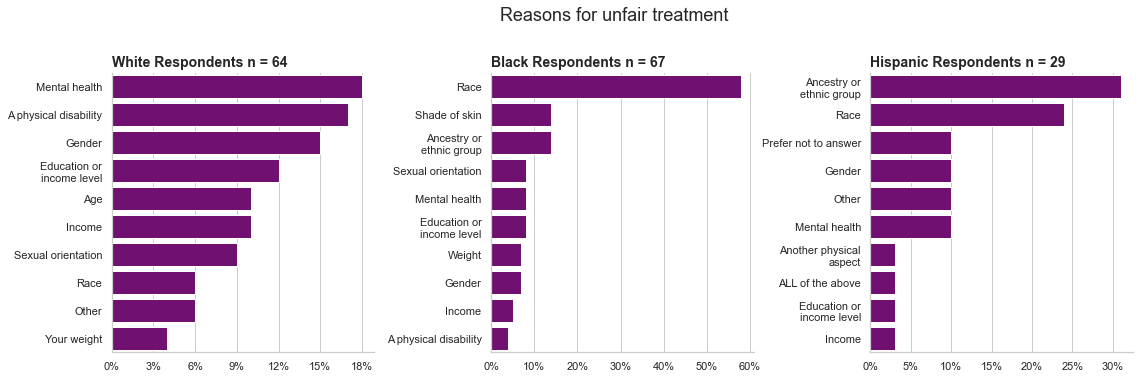

In [130]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Reasons for unfair treatment', fontsize=18, y=1.05)
fig.tight_layout(w_pad=7)


sns.barplot(ax=axs[0], x=white_pct.values, y=white_pct.index, color='#800080')
sns.despine()
axs[0].set_title('White Respondents n = 64', loc='left', fontdict={'weight':'bold'}, fontsize=14)
axs[0].set_xticks([0, 3, 6, 9, 12, 15, 18])
axs[0].set_xticklabels(['0%', '3%', '6%', '9%', '12%', '15%', '18%'])
# axs[0].set_xlim([0, 31])

sns.barplot(ax=axs[1],x=black_pct.values, y=black_pct.index, color='#800080')
sns.despine()
axs[1].set_title('Black Respondents n = 67', loc='left', fontdict={'weight':'bold'}, fontsize=14)
axs[1].set_xticks([0, 10, 20, 30, 40, 50, 60])
axs[1].set_xticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%'])

sns.barplot(ax=axs[2],x=latino_pct.values, y=latino_pct.index, color='#800080')
sns.despine()
axs[2].set_title('Hispanic Respondents n = 29', loc='left', fontdict={'weight':'bold'}, fontsize=14)
axs[2].set_xticks([0, 5, 10, 15, 20, 25, 30])
axs[2].set_xticklabels(['0%', '5%','10%','15%','20%','25%','30%'])

plt.savefig('./Figures/'+ 'reasons treated unfairly', bbox_inches = 'tight', edgecolor='w', dpi=300);